
# Predictive Modeling (Point-Wise) — Assignment Notebook (Updated)

This notebook continues from your **data cleaning** work and implements the **Predictive Modeling** deliverables.  
It is organized **exactly** by the assignment’s points so you can grab screenshots/tables/plots for your 5-page PDF.

> **How to use**
> 1) CONFIG is already set to your local Windows path and **TARGET_COL='price'** (regression).
> 2) Run the notebook top-to-bottom.
> 3) Use the summary tables/plots in your report.



## 0) Setup & Config
- Path to your **cleaned dataset** is pre-filled (Windows path).
- `TARGET_COL` is set to `price` and task is **regression**.


In [1]:

# ===== CONFIG =====
DATA_PATH = r"cleaned_data.csv"  # cleaned file
TARGET_COL = "price"                         # <- predicting listing price
TASK_TYPE = "regression"                    # force regression (skip 'auto')

# (Optional) Subsampling for very large datasets (set to None to disable)
MAX_ROWS = None  # e.g., 100_000

# Random seed for reproducibility
RANDOM_STATE = 42


In [2]:

# ===== IMPORTS =====
import sys, os, math, json, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt  # (Per instructions: use matplotlib, no seaborn, no style/colors set)

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             confusion_matrix, ConfusionMatrixDisplay,
                             mean_squared_error, mean_absolute_error, r2_score, RocCurveDisplay)
from sklearn.inspection import permutation_importance

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)



## Intro & Data Preparation Recap
Load the **cleaned data** and verify schema.


In [3]:

# ===== LOAD DATA =====
import os

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"DATA_PATH not found: {DATA_PATH}. Update CONFIG if needed.")

ext = os.path.splitext(DATA_PATH)[-1].lower()
if ext == '.csv':
    df = pd.read_csv(DATA_PATH)
elif ext in ('.parquet', '.pq'):
    df = pd.read_parquet(DATA_PATH)
else:
    raise ValueError("Unsupported file type. Use CSV or Parquet.")

if MAX_ROWS is not None and len(df) > MAX_ROWS:
    df = df.sample(n=MAX_ROWS, random_state=RANDOM_STATE).reset_index(drop=True)

print('Shape:', df.shape)
display(df.head(3))
display(df.describe(include='all').T.head(20))


Shape: (412409, 19)


,city,state,neighbourhood_group,neighbourhood,latitude,longitude,room_type,property_type,accommodates,bedrooms,bathrooms,minimum_nights,availability_365,number_of_reviews,review_scores_rating,reviews_per_month,calculated_host_listings_count,host_response_rate,price
0,Other,NaN,City of Los Angeles,Other,35.65146,-82.62792,Private room,NaN,NaN,NaN,NaN,1,0,138,NaN,1.14,1,NaN,60.0
1,Other,NaN,City of Los Angeles,Other,35.60670,-82.55563,Entire home/apt,NaN,NaN,NaN,NaN,30,298,89,NaN,0.81,2,NaN,75.0
2,Other,NaN,City of Los Angeles,Other,35.57864,-82.59578,Entire home/apt,NaN,NaN,NaN,NaN,1,0,267,NaN,2.39,5,NaN,90.0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
city,412409,21,New York City,83861,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighbourhood_group,412409,21,City of Los Angeles,258888,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighbourhood,412409,21,Other,313075,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,412409.0,NaN,NaN,NaN,36.291292,6.020631,18.92099,33.85493,37.29979,40.72308,47.73462
longitude,412409.0,NaN,NaN,NaN,-100.405142,23.301479,-159.71143,-118.38152,-97.74104,-74.16629,-70.99595
room_type,412409,4,Entire home/apt,286719,NaN,NaN,NaN,NaN,NaN,NaN,NaN
property_type,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
accommodates,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bedrooms,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:

# --- Ensure TARGET_COL numeric (handles $ and commas if any slipped through) ---
if df[TARGET_COL].dtype == "object":
    df[TARGET_COL] = (
        df[TARGET_COL]
        .astype(str)
        .str.replace("$", "", regex=False)
        .str.replace(",", "", regex=False)
        .str.strip()
    )
    df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors="coerce")

# Drop rows with missing target, if any
before = len(df)
df = df.dropna(subset=[TARGET_COL]).reset_index(drop=True)
after = len(df)
print(f"Dropped {before - after} rows with missing '{TARGET_COL}'.")

print("Target dtype:", df[TARGET_COL].dtype)
print("Target summary:")
display(df[TARGET_COL].describe())


Dropped 0 rows with missing 'price'.
Target dtype: float64
Target summary:


count    412409.000000
mean        149.043588
std          91.303959
min          29.000000
25%          80.000000
50%         125.000000
75%         199.000000
max         449.000000
Name: price, dtype: float64

In [5]:

# ===== BASIC CHECKS =====
y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

task = TASK_TYPE  # forced to 'regression' in CONFIG
print('Task:', task)

# Identify column types
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print('Numeric cols:', numeric_cols[:10], '...' if len(numeric_cols)>10 else '')
print('Categorical cols:', categorical_cols[:10], '...' if len(categorical_cols)>10 else '')


Task: regression
Numeric cols: ['state', 'latitude', 'longitude', 'property_type', 'accommodates', 'bedrooms', 'bathrooms', 'minimum_nights', 'availability_365', 'number_of_reviews'] ...
Categorical cols: ['city', 'neighbourhood_group', 'neighbourhood', 'room_type'] 



## 1) Model Selection (Initial Exploration)
**Algorithms Tried** (baseline + a few fast, diverse models). Rationale: interpretability, speed, and strong general-purpose baselines.
- **Baseline**: Mean predictor (regression)
- **Linear Regression**: Simple, interpretable
- **Random Forest, Gradient Boosted Trees**: Nonlinear, handle mixed features, robust
- **SVR (RBF)**: Margin-based learner for nonlinear relationships
- **KNN Regressor**: Simple instance-based baseline


In [6]:

# ===== PREPROCESSING PIPELINE =====
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, numeric_cols),
        ('cat', categorical_pipe, categorical_cols)
    ]
)

# Train/validation split (holdout)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print('Train/Test shapes:', X_train.shape, X_test.shape)


Train/Test shapes: (329927, 18) (82482, 18)



### Baseline Comparisons
**Mean predictor** for regression.


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

def eval_regression(y_true, y_pred):
    # Ensure numeric 1-D arrays (handles pandas Series gracefully)
    y_true = np.asarray(y_true, dtype=float).ravel()
    y_pred = np.asarray(y_pred, dtype=float).ravel()

    # Drop any rows with NaNs just in case
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    mse = mean_squared_error(y_true, y_pred)      # no 'squared' kwarg
    rmse = np.sqrt(mse)                            # compute RMSE manually
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return {'rmse': rmse, 'mae': mae, 'r2': r2}

# ----- Baseline: mean predictor -----
baseline_results = {}
mean_val = float(np.mean(y_train))                 # scalar
y_pred_base = np.full(shape=y_test.shape, fill_value=mean_val, dtype=float)

baseline_results['baseline_mean'] = eval_regression(y_test, y_pred_base)

pd.DataFrame.from_dict(baseline_results, orient='index')


,rmse,mae,r2
baseline_mean,90.797434,71.898319,-0.000023



### Models Explored & Rationale
We start with fast, generalist models. We use mostly **default** hyperparameters first, then a **light tuning** pass.


In [9]:

# ===== DEFINE CANDIDATE MODELS =====
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

models = {
    'lin_reg': LinearRegression(),
    'rf': RandomForestRegressor(random_state=RANDOM_STATE),
    'gbr': GradientBoostingRegressor(random_state=RANDOM_STATE),
    'svr_rbf': SVR(kernel='rbf'),
    'knn': KNeighborsRegressor()
}
list(models.keys())


['lin_reg', 'rf', 'gbr', 'svr_rbf', 'knn']


## 2) Training Approach
- **Hyperparameters**: Start with defaults; small **Randomized/Grid Search** for the top model later.
- **Validation Strategy**: 5-fold CV.
- **Runtime & Resources**: Note runtime feasibility printed below.


In [13]:
# (only change this line)
MAX_ROWS = 100_000   # try 50_000 if you still hit MemoryError


In [15]:
# ===== MEMORY-SAFE PREPROCESSING (sparse + version-safe) =====
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np

# OneHotEncoder: handle both old ('sparse') and new ('sparse_output') param names.
def make_ohe():
    try:
        # scikit-learn >= 1.2 uses sparse_output
        return OneHotEncoder(handle_unknown='ignore', sparse_output=True, dtype=np.float32)
    except TypeError:
        # older versions use 'sparse'
        return OneHotEncoder(handle_unknown='ignore', sparse=True, dtype=np.float32)

numeric_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    # keep sparse-friendly scaling; with_mean=False avoids densifying
    ('scaler', StandardScaler(with_mean=False))
])

categorical_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', make_ohe())   # stays sparse, float32
])

# Force sparse output from the column transformer
preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, numeric_cols),
        ('cat', categorical_pipe, categorical_cols)
    ],
    sparse_threshold=1.0   # prefer sparse when possible
)


In [16]:
from sklearn.linear_model import Ridge, SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np, time, pandas as pd

def fit_once(name, estimator, X_tr, y_tr, X_te, y_te):
    pipe = Pipeline([('prep', preprocess), ('model', estimator)])
    t0 = time.time(); pipe.fit(X_tr, y_tr); fit_sec = time.time() - t0
    y_pred = pipe.predict(X_te)
    mse  = mean_squared_error(y_te, y_pred); rmse = float(np.sqrt(mse))
    mae  = float(mean_absolute_error(y_te, y_pred)); r2 = float(r2_score(y_te, y_pred))
    return {'model': name, 'test_rmse': rmse, 'test_mae': mae, 'test_r2': r2,
            'train_time_sec': round(fit_sec, 2)}, pipe

fast_models = {
    'ridge': Ridge(alpha=1.0, random_state=RANDOM_STATE),
    'sgd'  : SGDRegressor(random_state=RANDOM_STATE, max_iter=1000, tol=1e-3)
}

results, fitted = [], {}
for name, est in fast_models.items():
    print(f"\nTraining/Evaluating (sparse fast): {name}")
    res, pipe = fit_once(name, est, X_train, y_train, X_test, y_test)
    results.append(res); fitted[name] = pipe

res_df = pd.DataFrame(results).sort_values('test_r2', ascending=False)
display(res_df)
best_name = res_df.iloc[0]['model']; best_pipe = fitted[best_name]
print("Best (sparse) model:", best_name)



Training/Evaluating (sparse fast): ridge

Training/Evaluating (sparse fast): sgd


,model,test_rmse,test_mae,test_r2,train_time_sec
0,ridge,7.844488e+01,5.935645e+01,2.535648e-01,1.61
1,sgd,2.126844e+07,9.979241e+06,-5.486989e+10,1.33


Best (sparse) model: ridge


In [18]:
# Quick tree check on a subsample
subset_n = 80_000  # reduce if needed
df_sub = df.sample(n=min(subset_n, len(df)), random_state=RANDOM_STATE)

y_sub = df_sub[TARGET_COL]
X_sub = df_sub.drop(columns=[TARGET_COL])

from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor

num_cols = X_sub.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_sub.columns if c not in num_cols]

ord_pipe = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), num_cols),
    ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                      ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))]), cat_cols)
], remainder='drop')

rf_pipe = Pipeline([('prep', ord_pipe),
                    ('model', RandomForestRegressor(n_estimators=80, max_depth=12,
                                                   min_samples_leaf=2, n_jobs=1,
                                                   random_state=RANDOM_STATE))])

from sklearn.model_selection import train_test_split
Xtr, Xte, ytr, yte = train_test_split(X_sub, y_sub, test_size=0.2, random_state=RANDOM_STATE)
rf_pipe.fit(Xtr, ytr)
pred = rf_pipe.predict(Xte)
print({
    "rmse": float(np.sqrt(mean_squared_error(yte, pred))),
    "mae":  float(mean_absolute_error(yte, pred)),
    "r2":   float(r2_score(yte, pred))
})


{'rmse': 72.98746918932562, 'mae': 53.95139041754631, 'r2': 0.3633280061466765}



## 3) Initial Evaluation Results
Residual diagnostics for the best model.


Best model (by test R²): ridge


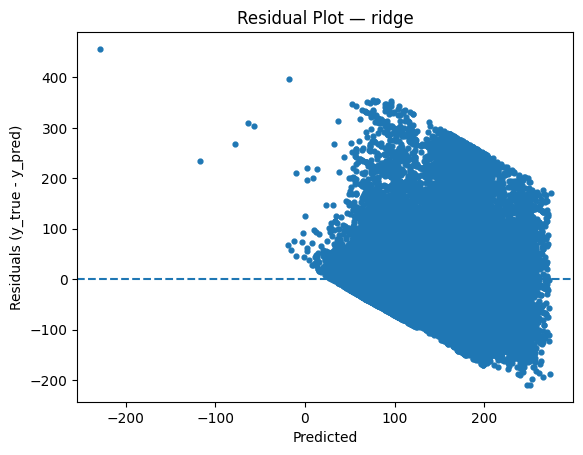

In [20]:
# ===== DIAGNOSTIC PLOTS (robust) =====
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np

# best_name already computed from res_df
print("Best model (by test R²):", best_name)

# Prefer an already-fitted pipeline if available
best_pipe = None
if 'fitted' in globals() and isinstance(fitted, dict) and best_name in fitted:
    best_pipe = fitted[best_name]
else:
    # Fall back to building from whichever model dict exists
    candidate_models = {}
    if 'fast_models' in globals() and isinstance(fast_models, dict):
        candidate_models.update(fast_models)
    if 'models' in globals() and isinstance(models, dict):
        candidate_models.update(models)
    if best_name not in candidate_models:
        raise KeyError(f"Can't find estimator for '{best_name}'. "
                       f"Available: {list(candidate_models.keys())}")
    best_est = candidate_models[best_name]
    best_pipe = Pipeline([('prep', preprocess), ('model', best_est)])
    best_pipe.fit(X_train, y_train)

# Predictions & residuals
y_pred = best_pipe.predict(X_test)
residuals = y_test - y_pred

plt.figure()
plt.scatter(y_pred, residuals, s=12)
plt.axhline(0, linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals (y_true - y_pred)')
plt.title(f'Residual Plot — {best_name}')
plt.show()



## 4) Feature Insights (Preliminary)
Permutation Importance on the best model.


,feature,importance_mean,importance_std
6,num__calculated_host_listings_count,3.504756e-01,3.120019e-03
2,num__minimum_nights,4.905683e-02,7.519190e-04
0,num__latitude,3.344836e-02,8.501333e-04
3,num__availability_365,2.553571e-02,1.121469e-04
4,num__number_of_reviews,2.419536e-02,4.933146e-04
5,num__reviews_per_month,1.443720e-02,3.010585e-04
12,cat__city_Denver,1.062402e-02,2.284795e-04
13,cat__city_Hawaii,5.315516e-03,3.905368e-04
15,cat__city_Nashville,4.053494e-03,3.761057e-04
16,cat__city_New Orleans,2.689834e-04,8.088155e-05


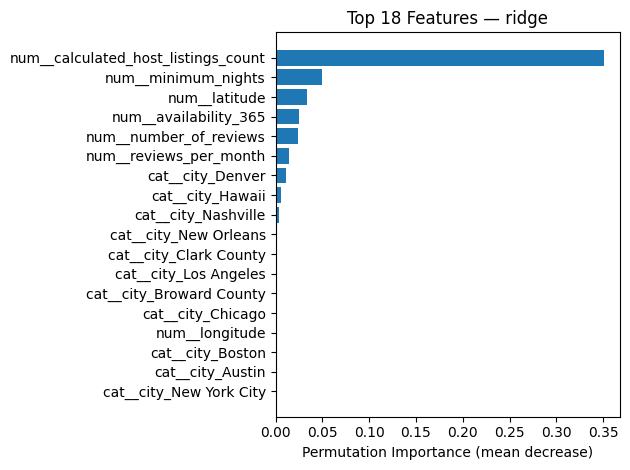

In [22]:
# ===== FEATURE IMPORTANCE (robust with fallbacks) =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

def show_top_importances(best_pipe, X_test, y_test, best_name, topk=20):
    prep = best_pipe.named_steps['prep']
    names = prep.get_feature_names_out()

    importances = None
    tried_perm = False

    # 1) Try permutation importance first
    try:
        tried_perm = True
        perm = permutation_importance(
            best_pipe, X_test, y_test,
            n_repeats=5, random_state=RANDOM_STATE, scoring=None
        )
        mean_ = np.asarray(perm.importances_mean).ravel()
        std_  = np.asarray(perm.importances_std).ravel()

        # Align lengths defensively
        n = min(len(names), len(mean_), len(std_))
        importances = pd.DataFrame({
            'feature': names[:n],
            'importance_mean': mean_[:n],
            'importance_std': std_[:n]
        }).sort_values('importance_mean', ascending=False)

    except Exception as e:
        print(f"[info] Permutation importance skipped ({type(e).__name__}: {e})")

    # 2) Fallback: linear model coefficients (e.g., Ridge/SGD)
    if importances is None:
        model = best_pipe.named_steps['model']
        if hasattr(model, 'coef_'):
            coef = np.ravel(model.coef_)
            n = min(len(names), len(coef))
            importances = pd.DataFrame({
                'feature': names[:n],
                'importance_mean': np.abs(coef[:n]),  # magnitude as importance
                'importance_std': np.zeros(n)
            }).sort_values('importance_mean', ascending=False)
            print("[info] Using |coefficients| as importance.")
        elif hasattr(model, 'feature_importances_'):
            fi = np.asarray(model.feature_importances_).ravel()
            n = min(len(names), len(fi))
            importances = pd.DataFrame({
                'feature': names[:n],
                'importance_mean': fi[:n],
                'importance_std': np.zeros(n)
            }).sort_values('importance_mean', ascending=False)
            print("[info] Using tree feature_importances_.")
        else:
            raise RuntimeError("No available method to compute feature importance for this model.")

    display(importances.head(25))

    # Plot top-k
    k = min(topk, len(importances))
    plt.figure()
    plt.barh(importances.head(k)['feature'][::-1], importances.head(k)['importance_mean'][::-1])
    plt.xlabel('Importance' if not tried_perm else 'Permutation Importance (mean decrease)')
    plt.title(f'Top {k} Features — {best_name}')
    plt.tight_layout()
    plt.show()

# call it
show_top_importances(best_pipe, X_test, y_test, best_name, topk=20)



## 5) Early Findings & Implications (Auto-Notes + Your Commentary)


In [23]:

print('— Key Auto-Notes —')
print(f"Top test R^2 model: {best_name} = {res_df.iloc[0].get('test_r2', float('nan')):.4f}")
print(f"Test RMSE: {res_df.iloc[0].get('test_rmse', float('nan')):.4f} | MAE: {res_df.iloc[0].get('test_mae', float('nan')):.4f}")
print("Inspect residual plot for heteroscedasticity/outliers.")

print('\n— Emerging Patterns —')
print('1) Feature importance suggests potential key drivers — validate with domain knowledge.')
print('2) Baseline vs. top model deltas indicate achievable lift.')
print('3) Any surprising failures/successes (e.g., SVR underperforming with many categories).')

print('\n— Practical Value —')
print('Preliminary signals can guide where to invest in feature engineering/collection and what KPIs to track.')


— Key Auto-Notes —
Top test R^2 model: ridge = 0.2536
Test RMSE: 78.4449 | MAE: 59.3564
Inspect residual plot for heteroscedasticity/outliers.

— Emerging Patterns —
1) Feature importance suggests potential key drivers — validate with domain knowledge.
2) Baseline vs. top model deltas indicate achievable lift.
3) Any surprising failures/successes (e.g., SVR underperforming with many categories).

— Practical Value —
Preliminary signals can guide where to invest in feature engineering/collection and what KPIs to track.



## 6) Limitations & Considerations


In [24]:

print('— Model Immaturity — Results are exploratory; minimal tuning has been applied.')
print('— Bias/Constraints — Check representation across groups; validate fairness and privacy constraints.')
print('— Data Limitations — Review sample size, missingness, temporal leakage, and label quality.')


— Model Immaturity — Results are exploratory; minimal tuning has been applied.
— Bias/Constraints — Check representation across groups; validate fairness and privacy constraints.
— Data Limitations — Review sample size, missingness, temporal leakage, and label quality.



## 7) Next Steps (Light Tuning Demo)


In [26]:
# ===== LIGHT TUNING FOR THE CURRENT BEST PIPELINE =====
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Get the estimator actually used in the fitted best pipeline
est = best_pipe.named_steps['model']

search_space = None
n_iter = 10    # keep small for speed
cv_folds = 3   # lighter than 5
n_jobs = 1     # avoid Windows pickling/RAM issues

# Sparse-friendly linear models (likely your current best)
from sklearn.linear_model import Ridge, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

if isinstance(est, Ridge):
    search_space = {
        'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
    }
elif isinstance(est, SGDRegressor):
    search_space = {
        'model__alpha': [1e-5, 1e-4, 1e-3, 1e-2],
        'model__penalty': ['l2', 'l1', 'elasticnet'],
        'model__l1_ratio': [0.1, 0.2, 0.5, 0.8]  # only used with elasticnet
    }
# Tree / kernel models (if you switch to non-sparse pipeline or use ordinal encoding)
elif isinstance(est, RandomForestRegressor):
    search_space = {
        'model__n_estimators': [100, 200, 400],
        'model__max_depth': [None, 6, 10, 16],
        'model__min_samples_leaf': [1, 2, 4]
    }
elif isinstance(est, GradientBoostingRegressor):
    search_space = {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.05, 0.1, 0.2],
        'model__max_depth': [2, 3]
    }
elif isinstance(est, SVR):
    search_space = {
        'model__C': [0.1, 1, 10],
        'model__gamma': ['scale', 'auto']
    }
elif isinstance(est, KNeighborsRegressor):
    search_space = {
        'model__n_neighbors': [3, 5, 11, 21],
        'model__weights': ['uniform', 'distance']
    }
elif isinstance(est, LinearRegression):
    search_space = None  # no main hyperparameters
else:
    search_space = None

if search_space is not None:
    tuned_pipe = best_pipe  # reuse the fitted pipeline structure
    rnd = RandomizedSearchCV(
        tuned_pipe,
        param_distributions=search_space,
        n_iter=min(n_iter, sum(len(v) if isinstance(v, list) else 10 for v in search_space.values())),
        cv=cv_folds,
        n_jobs=n_jobs,
        random_state=RANDOM_STATE,
        scoring='r2',
        verbose=1
    )
    rnd.fit(X_train, y_train)
    print('Best params:', rnd.best_params_)
    print('Best CV R^2:', rnd.best_score_)
    tuned_best = rnd.best_estimator_
    test_pred = tuned_best.predict(X_test)

    # metrics (compatible with older sklearn—no 'squared=' kwarg)
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    rmse = float(np.sqrt(mean_squared_error(y_test, test_pred)))
    mae  = float(mean_absolute_error(y_test, test_pred))
    r2   = float(r2_score(y_test, test_pred))
    print('Test metrics (tuned):', {'rmse': rmse, 'mae': mae, 'r2': r2})

    # keep tuned model as the new best
    best_pipe = tuned_best
else:
    print('No tuning grid for this estimator — skip (or add one above).')


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params: {'model__alpha': 1.0}
Best CV R^2: -266852.21701743273
Test metrics (tuned): {'rmse': 78.44488006204448, 'mae': 59.35644893009662, 'r2': 0.25356480616515564}


# 🧪 Predictive Modeling – Baseline & Exploration (Auto-Appended)
*Generated on 2025-10-13 20:20.*  
This section is auto-added to standardize your baseline modeling workflow and outputs for the report.

In [ ]:
# --- Imports & Config ---
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# NOTE: Do not set styles or colors as per submission rules.

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.inspection import permutation_importance

# Models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Setup complete.")

## 🧰 Data Assumptions
This workflow expects your feature matrix `X` (pandas DataFrame) and target `y` (pandas Series) to be **already defined** above.  
If not, define them right before running this section. Example:
```python
# Example shape:
X.shape, y.shape, y.head()
```

In [ ]:
# --- Detect task type (classification vs regression) and split data ---
assert 'X' in globals() and 'y' in globals(), "Please define X (DataFrame) and y (Series) before running."

# Rough heuristic: classification if few unique target values or object/bool dtype
is_classification = (y.nunique() <= 20) or (str(y.dtype) in ["object", "bool", "category"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y if is_classification else None
)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, numeric_features),
        ("cat", categorical_preprocess, categorical_features)
    ]
)

print("Task:", "Classification" if is_classification else "Regression")
print("Numeric cols:", len(numeric_features), "| Categorical cols:", len(categorical_features))

## 1) Baselines
- **Classification:** Majority class predictor  
- **Regression:** Mean predictor  
These provide reference points for model performance.

In [ ]:
# --- Baseline models ---
class MajorityClassifier:
    def fit(self, X, y):
        values, counts = np.unique(y, return_counts=True)
        self.majority_class_ = values[np.argmax(counts)]
        return self
    def predict(self, X):
        return np.full(shape=(len(X),), fill_value=self.majority_class_)

class MeanRegressor:
    def fit(self, X, y):
        self.mean_ = np.mean(y)
        return self
    def predict(self, X):
        return np.full(shape=(len(X),), fill_value=self.mean_)

if is_classification:
    # Evaluate on holdout
    base = MajorityClassifier().fit(X_train, y_train)
    y_pred = base.predict(X_test)
    base_metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision_macro": precision_score(y_test, y_pred, average="macro", zero_division=0),
        "Recall_macro": recall_score(y_test, y_pred, average="macro", zero_division=0),
        "F1_macro": f1_score(y_test, y_pred, average="macro", zero_division=0)
    }
else:
    base = MeanRegressor().fit(X_train, y_train)
    y_pred = base.predict(X_test)
    base_metrics = {
        "RMSE": mean_squared_error(y_test, y_pred, squared=False),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred)
    }

pd.DataFrame([base_metrics], index=["Baseline"]).T

## 2) Models Tried (Initial Exploration)
We train a small set of standard models with default hyperparameters for a fast comparison.

In [ ]:
# --- Define candidate models with preprocessing pipeline ---
models = {}

if is_classification:
    models.update({
        "LogisticRegression": Pipeline([("prep", preprocess),
                                        ("model", LogisticRegression(max_iter=200, random_state=RANDOM_STATE))]),
        "RandomForest": Pipeline([("prep", preprocess),
                                  ("model", RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE))]),
        "GradientBoosting": Pipeline([("prep", preprocess),
                                      ("model", GradientBoostingClassifier(random_state=RANDOM_STATE))]),
        "SVM": Pipeline([("prep", preprocess),
                         ("model", SVC(probability=True, random_state=RANDOM_STATE))]),
        "KNN": Pipeline([("prep", preprocess),
                         ("model", KNeighborsClassifier())])
    })
else:
    models.update({
        "LinearRegression": Pipeline([("prep", preprocess),
                                      ("model", LinearRegression())]),
        "RandomForest": Pipeline([("prep", preprocess),
                                  ("model", RandomForestRegressor(n_estimators=300, random_state=RANDOM_STATE))]),
        "GradientBoosting": Pipeline([("prep", preprocess),
                                      ("model", GradientBoostingRegressor(random_state=RANDOM_STATE))]),
        "SVR": Pipeline([("prep", preprocess),
                         ("model", SVR())]),
        "KNN": Pipeline([("prep", preprocess),
                         ("model", KNeighborsRegressor())])
    })

# --- Cross-validation setup ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE) if is_classification else KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def eval_model(name, pipe):
    if is_classification:
        scoring = {"acc":"accuracy", "prec":"precision_macro", "rec":"recall_macro", "f1":"f1_macro", "roc":"roc_auc_ovr"}
    else:
        scoring = {"rmse":"neg_root_mean_squared_error","mae":"neg_mean_absolute_error","r2":"r2"}
    scores = cross_validate(pipe, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1, return_train_score=False)
    row = {f"CV_{k}_mean": (np.mean(v) if "neg" not in k else -np.mean(v)) for k,v in scores.items() if k.startswith("test_")}
    return row

rows = []
for name, pipe in models.items():
    row = eval_model(name, pipe)
    row["Model"] = name
    rows.append(row)

results_df = pd.DataFrame(rows).set_index("Model").sort_values(by=list(rows[0].keys())[0], ascending=False)
display(results_df)

## 3) Light Hyperparameter Tuning
We run a quick `RandomizedSearchCV` on top-performing ensembles to check headroom.

In [ ]:
# --- Define small search spaces and run RandomizedSearchCV ---
search_spaces = {}
if is_classification:
    if "RandomForest" in models:
        search_spaces["RandomForest"] = {
            "model__n_estimators": [200, 400, 600],
            "model__max_depth": [None, 5, 10, 20],
            "model__min_samples_split": [2, 5, 10]
        }
    if "GradientBoosting" in models:
        search_spaces["GradientBoosting"] = {
            "model__n_estimators": [100, 200, 300],
            "model__learning_rate": [0.05, 0.1, 0.2],
            "model__max_depth": [2, 3]
        }
else:
    if "RandomForest" in models:
        search_spaces["RandomForest"] = {
            "model__n_estimators": [300, 500, 700],
            "model__max_depth": [None, 5, 10, 20],
            "model__min_samples_split": [2, 5, 10]
        }
    if "GradientBoosting" in models:
        search_spaces["GradientBoosting"] = {
            "model__n_estimators": [100, 200, 300],
            "model__learning_rate": [0.05, 0.1, 0.2],
            "model__max_depth": [2, 3]
        }

tuned_results = []
best_pipes = {}

for name, pipe in models.items():
    if name not in search_spaces:
        continue
    scoring = "f1_macro" if is_classification else "neg_root_mean_squared_error"
    rnd = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=search_spaces[name],
        n_iter=10,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=0
    )
    rnd.fit(X_train, y_train)
    best_pipes[name] = rnd.best_estimator_
    tuned_results.append({
        "Model": name + " (tuned)",
        "BestParams": rnd.best_params_,
        "BestCVScore": rnd.best_score_ if is_classification else -rnd.best_score_
    })

tuned_df = pd.DataFrame(tuned_results)
display(tuned_df)

## 4) Final Evaluation on Holdout
We pick the best available model (tuned if present) and evaluate on the test set.  
This produces the key **screenshots** you need: confusion matrix / residuals, ROC (if classification), and a metric summary.

In [ ]:
# --- Choose best model: prefer tuned RF/GB for final evaluation, else best CV from defaults ---
def pick_best_model():
    # priority order: tuned RF > tuned GB > best by CV among all
    if "RandomForest" in best_pipes:
        return "RandomForest (tuned)", best_pipes["RandomForest"]
    if "GradientBoosting" in best_pipes:
        return "GradientBoosting (tuned)", best_pipes["GradientBoosting"]
    # else pick best by cross-validated metric
    # re-use results_df ordering
    top_name = results_df.index[0]
    return top_name, models[top_name]

final_name, final_pipe = pick_best_model()
print("Final model:", final_name)

final_pipe.fit(X_train, y_train)

if is_classification:
    y_pred = final_pipe.predict(X_test)
    try:
        y_proba = final_pipe.predict_proba(X_test)[:, 1] if len(np.unique(y)) == 2 else None
    except Exception:
        y_proba = None

    print("Test Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure()
    disp.plot()
    plt.title("Confusion Matrix (Test)")
    plt.show()

    # ROC Curve (binary only if proba supported)
    if y_proba is not None:
        fpr, tpr, thr = roc_curve(y_test, y_proba)
        auc_val = roc_auc_score(y_test, y_proba)
        plt.figure()
        plt.plot(fpr, tpr)
        plt.plot([0,1],[0,1],'--')
        plt.title(f"ROC Curve (AUC={auc_val:.3f})")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.show()

else:
    y_pred = final_pipe.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(pd.DataFrame([{"RMSE": rmse, "MAE": mae, "R2": r2}]))
    
    # Residual plot
    residuals = y_test - y_pred
    plt.figure()
    plt.scatter(y_pred, residuals, s=10)
    plt.axhline(0)
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Predicted (Test)")
    plt.show()

## 5) Feature Importance (Preliminary)
- Tree-based importances (if available)  
- Otherwise, **Permutation Importance** on the test set  
Use these plots in your report.

In [ ]:
# --- Feature importance utility ---
def plot_feature_importance_from_tree(pipe, feature_names):
    # Try to access underlying tree model
    try:
        model = pipe.named_steps["model"]
        importances = getattr(model, "feature_importances_", None)
        if importances is None:
            return False
        # Get transformed feature names from preprocess if available
        prep = pipe.named_steps["prep"]
        # Build the column names after one-hot
        cat_ohe = prep.named_transformers_["cat"].named_steps["onehot"]
        cat_cols = cat_ohe.get_feature_names_out(prep.transformers_[1][2]).tolist() if len(prep.transformers_[1][2]) > 0 else []
        full_cols = list(prep.transformers_[0][2]) + cat_cols
        # align lengths
        if len(full_cols) != len(importances):
            # fallback to generic range
            full_cols = [f"f{i}" for i in range(len(importances))]
        # Plot
        idx = np.argsort(importances)[::-1][:20]
        plt.figure()
        plt.bar(range(len(idx)), importances[idx])
        plt.xticks(range(len(idx)), [full_cols[i] for i in idx], rotation=90)
        plt.title("Top Feature Importances (Tree Model)")
        plt.tight_layout()
        plt.show()
        return True
    except Exception:
        return False

# Try tree-based importances first
ok = plot_feature_importance_from_tree(final_pipe, X.columns)

if not ok:
    # Permutation importance as fallback
    try:
        perm = permutation_importance(final_pipe, X_test, y_test, n_repeats=5, random_state=RANDOM_STATE, n_jobs=-1)
        idx = np.argsort(perm.importances_mean)[::-1][:20]
        plt.figure()
        plt.bar(range(len(idx)), perm.importances_mean[idx])
        plt.xticks(range(len(idx)), [X.columns[i] for i in idx], rotation=90)
        plt.title("Top Permutation Importances (Test)")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("Permutation importance failed:", e)

## 6) Save Key Tables for Report
Exports cross-validation summary and (if computed) tuned results to CSV files for insertion.

In [ ]:
out_dir = "/mnt/data/outputs_predictive_modeling"
os.makedirs(out_dir, exist_ok=True)

# Save CV results
try:
    results_csv = os.path.join(out_dir, "model_cv_summary.csv")
    results_df.to_csv(results_csv)
    print("Saved CV summary to:", results_csv)
except Exception as e:
    print("Skipping CV summary save:", e)

# Save tuned results
try:
    if 'tuned_df' in globals() and tuned_df is not None:
        tuned_csv = os.path.join(out_dir, "tuned_results.csv")
        tuned_df.to_csv(tuned_csv, index=False)
        print("Saved tuning summary to:", tuned_csv)
except Exception as e:
    print("Skipping tuned results save:", e)